In [1]:
# import numpy as np
# import torch
# import warnings
# from copy.deepcopy(Munch import copy.deepcopy(Munch
# import itertools
# from mv_Viterbi import mv_Viterbi
# from cst_aggregate import cst_aggregate

import numpy as np
import torch
import json
from munch import Munch
import itertools
from collections import defaultdict
import random
import copy
import pickle
import matplotlib.pyplot as plt
import importlib
import time


### Create the HMM

In [199]:
hidden_states = ['pro','ex1','ex2','int','dis','enh']
emit_states = ['A','T', 'C', 'G']
hidden_size, emit_size = len(hidden_states), len(emit_states)

hmm_mat = np.array([
    [.6,.1,.1,.2,0,0], #promoter
    [0,.4,.3,.2,.1,0], #exon1
    [.0,.3,.4,0,.2,.1], #exon2
    [.1,.1,.1,.6,0,.1], #intron
    [0,1/3, 1/3, 0,1/3,0], #disease
    [0,.25,.25,.25,0,.25] #enhancer
])

emit_mat = np.array([ #
    [.1,.1,.4,.4], #CG rich promoter
    [.1,.1,.7,.1], #Exon 1 favors C
    [.7,.1,.1,.1], #Exon 2 favors A
    [.25,.25,.25,.25], #Intron 
    [.5,0,.5,0], #Disease favors AC
    [.4,.4,.1,.1] #AT rich enhancer
])

init_vec = np.array(
    [.5,0,0,.5,0,0]
)

hmm_transition = {}
for i in range(hidden_size):
    for j in range(hidden_size):
        hmm_transition[hidden_states[i],hidden_states[j]] = hmm_mat[i,j].item()

hmm_emit = {}
for i in range(hidden_size):
    for j in range(emit_size):
        hmm_emit[hidden_states[i],emit_states[j]] = emit_mat[i,j].item()
        
hmm_startprob = {}
for i in range(hidden_size):
    hmm_startprob[hidden_states[i]] = init_vec[i]

hmm = copy.deepcopy(Munch(states = hidden_states, emits = emit_states, tprob = hmm_transition, eprob = hmm_emit, initprob = hmm_startprob))

In [200]:
def create_cst_params(cst, hidden_states, dtype = torch.float32, device = 'cpu'):
    m_states = cst.m_states
    init = cst.init_fun
    upd = cst.update_fun
    eval_fun = cst.eval_fun

    #returns a (k,s,r) array. k is current hideen. r,s are present/past mediation.
    upd_mat = torch.tensor([[[upd(k,r,s) for s in m_states] for r in m_states] for k in hidden_states], dtype = dtype, device = device)

    #returns a (k,r) array. k,r are current hidden/mediation states
    init_mat = torch.tensor([[init(k,r) for r in m_states] for k in hidden_states], dtype = dtype, device = device)

    #return (k,r) array for terminal emission.
    eval_mat = torch.tensor([[eval_fun(k,r) for r in m_states] for k in hidden_states], dtype = dtype, device = device)

    return init_mat, eval_mat, upd_mat


### Stay > = 3

In [201]:
def update_fun(k , r, r_past):
    '''
    r = hidden_states x [1,2,3, 4]
    '''
    prev, count = r_past #r is a tuple
    if k == prev:
        new_count = min(count + 1 , 3)
    else:
        new_count = 1
        
    if (count == 3 or k == prev) and r == (k, new_count):
        return True
    else:
        return False

def init_fun(k, r):
    '''
    initial "prob" of r = (m1,m2) from k. is just indicator
    '''

    return r == (k,1)

    
def eval_fun(k, r):
    return 1

m_states = list(itertools.product(hidden_states, list(range(1,4))))

stay_cst = Munch(update_fun = update_fun, init_fun = init_fun, eval_fun = eval_fun, m_states = m_states)

In [178]:
update_fun('enh',('pro',4), ('enh',1))

False

In [130]:
test_params = create_cst_params(stay_cst, hidden_states)

print(test_params[0].sum(axis = 1),test_params[1].sum(axis = 1),test_params[2].sum(axis = 1))

tensor([1., 1., 1., 1., 1., 1.]) tensor([24., 24., 24., 24., 24., 24.]) tensor([[1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.,
         0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
         1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         0., 1., 1., 1., 1., 1.]])


### Promoter Must Occur in First 10

In [131]:
def update_fun(k , r, r_past):
    '''
    r = Boolean
    tracks if 'pro' has occured yet or not
    '''        

    return r == (r_past or (k == 'pro')) 

def init_fun(k, r):

    return r == (k == 'pro')

def eval_fun(k,r):
    return 1

m_states = [True,False]

promoter_cst = copy.deepcopy(Munch(update_fun = update_fun, init_fun = init_fun, eval_fun = eval_fun, m_states = m_states))

In [132]:
test_params = create_cst_params(promoter_cst, hidden_states)

print(test_params[0].sum(axis = 1),test_params[1].sum(axis = 1),test_params[2].sum(axis = 1))

tensor([1., 1., 1., 1., 1., 1.]) tensor([2., 2., 2., 2., 2., 2.]) tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])


#### Visit Dis Exactly Once 

In [133]:
def update_fun(k , r, r_past):
    '''
    r =  [True,False] x [0,1,2]
    r[0] is True if previoius state was NOT dis.
    counts number of entries into dis (ie. number of dis regions)
    '''
    prev, count = r_past

    if prev and k == 'dis':
        count = min(count + 1, 2)    
    
    return r == (k != 'dis',count) 

def init_fun(k, r):

    if k == 'dis':
        return r == (False,1)
    else:
        return r == (True,0)

def eval_fun(k,r):
    return r[1] == 1 #must be exactly 1.

m_states = list(itertools.product([True,False], list(range(3))))


disvisit_cst = copy.deepcopy(Munch(update_fun = update_fun, init_fun = init_fun, eval_fun = eval_fun, m_states = m_states))

### Promoter < Disease < Enhancer

In [134]:
def update_fun(k , r, r_past):
    '''
    r = Boolean_pro x Bool_dis x Bool_enh
    trcks that they occur in sequence
    '''
    occur_pro, occur_dis, occur_enh = r_past
    consist = True
    
    pro_new = (k == 'pro' or occur_pro)
    dis_new = (k == 'dis' or occur_dis)
    enh_new = (k == 'enh' or occur_enh)

    if k == 'dis': #if at anytime dis occurs before pro, that sequence is zero'd out.
        consist = pro_new

    if k == 'enh':
        consist = dis_new 

    return (r == (pro_new, dis_new,enh_new)) and consist

def init_fun(k, r):

    return r == ( k == 'pro', k == 'dis', k == 'enh')

def eval_fun(k,r):
    return 1 #ensures that enhancer is in the sequence

    # return r[2] #ensures that enhancer is in the sequence

m_states = list(itertools.product([True, False], repeat=3))

pde_cst = copy.deepcopy(Munch(update_fun = update_fun, init_fun = init_fun, eval_fun = eval_fun, m_states = m_states))



In [259]:
def update_fun(k , r, r_past):
    '''
    r = Boolean_pro x Bool_dis x Bool_enh
    trcks that they occur in sequence
    '''
    occur_pro, occur_enh = r_past
    consist = True
    
    pro_new = (k == 'pro' or occur_pro)
    enh_new = (k == 'enh' or occur_enh)

    if k == 'enh':
        consist = pro_new 

    return (r == (pro_new,enh_new)) and consist

def init_fun(k, r):

    return r == ( k == 'pro', k == 'enh')

def eval_fun(k,r):
    return 1 #ensures that enhancer is in the sequence

    # return r[2] #ensures that enhancer is in the sequence

m_states = list(itertools.product([True, False], repeat=2))

pe_cst = copy.deepcopy(Munch(update_fun = update_fun, init_fun = init_fun, eval_fun = eval_fun, m_states = m_states))



# Hitting Constraint for Dis

In [260]:
def update_fun(k , r, r_past):
    '''
    r =  [True,False]
    r is a Boolean that tracks if dis has occured
    '''
        
    return r == (r_past or k == 'dis') 

def init_fun(k, r):

    return r == (k == 'dis')

def eval_fun(k,r):
    return r == True #dis has occured

m_states = [True,False]


hitdis_cst = copy.deepcopy(Munch(update_fun = update_fun, init_fun = init_fun, eval_fun = eval_fun, m_states = m_states))

### Visit Dis at most Once

In [297]:
def update_fun(k , r, r_past):
    '''
    r =  [True,False] x [0,1,2]
    r[0] is True if previoius state was NOT dis.
    counts number of entries into dis (ie. number of dis regions)
    '''
    prev, count = r_past

    if prev and k == 'dis':
        count = min(count + 1, 2)    
    
    return r == (k != 'dis',count) 

def init_fun(k, r):

    if k == 'dis':
        return r == (False,1)
    else:
        return r == (True,0)

def eval_fun(k,r):
    return r[1] != 2  #must be 0 or 1.

m_states = list(itertools.product([True,False], list(range(3))))


disvisit_atmost_cst = copy.deepcopy(Munch(update_fun = update_fun, init_fun = init_fun, eval_fun = eval_fun, m_states = m_states))

# Dummy Constraint

In [135]:
def update_fun(k, r, r_past):
    return r == True

def init_fun(k, r):

    return r == True

def eval_fun(k, r):
    return 1

m_states = [True,False]

dummy_cst = copy.deepcopy(Munch(update_fun = update_fun, init_fun = init_fun, eval_fun = eval_fun, m_states = m_states))


In [136]:
def create_cst_params(cst, hidden_states, dtype = torch.float32, device = 'cpu'):
    m_states = cst.m_states
    init = cst.init_fun
    upd = cst.update_fun
    eval_fun = cst.eval_fun

    #returns a (k,s,r) array. k is current hideen. r,s are present/past mediation.
    upd_mat = torch.tensor([[[upd(k,r,s) for s in m_states] for r in m_states] for k in hidden_states], dtype = dtype, device = device)

    #returns a (k,r) array. k,r are current hidden/mediation states
    init_mat = torch.tensor([[init(k,r) for r in m_states] for k in hidden_states], dtype = dtype, device = device)

    #return (k,r) array for terminal emission.
    eval_mat = torch.tensor([[eval_fun(k,r) for r in m_states] for k in hidden_states], dtype = dtype, device = device)

    return init_mat, eval_mat, upd_mat

def convertTensor_list(hmm, cst_list, dtype = torch.float16, device = 'cpu', hmm_params = None, return_ix = False):
    '''
    cst_list is a list of the individual csts.
    '''
    #Initialize and convert all quantities  to np.arrays
    hmm = copy.deepcopy(hmm)
    K = len(hmm.states)
    
    state_ix = {s: i for i, s in enumerate(hmm.states)}
    
    #Compute the hmm parameters if not provided
    if hmm_params is None:
        tmat = torch.zeros((K,K), dtype=dtype ).to(device)
        init_prob = torch.zeros(K, dtype=dtype ).to(device)
    
        for i in hmm.states:
            init_prob[state_ix[i]] = hmm.initprob[i]
            for j in hmm.states:
                tmat[state_ix[i],state_ix[j]] = hmm.tprob[i,j]
    
        hmm_params = [tmat, init_prob]
    
    #Compute the cst parameters 
    init_list = []
    eval_list = []
    upd_list = []
    dims_list = []
    cst_ix = 0
    C = len(cst_list)

    #indices are (hidden, c_1,....,c_C, hidden, c_1,....,c_C) are augmented messages
    for cst in cst_list:
        cst = copy.deepcopy(cst)
        init_mat, eval_mat, upd_mat = create_cst_params(cst, hidden_states, dtype = dtype, device = device)
        init_list += [init_mat,[0,cst_ix + 1]]
        eval_list += [eval_mat, [0, cst_ix + 1]]
        upd_list += [upd_mat, [0, cst_ix + 1,cst_ix + C + 2]]
        dims_list.append(len(cst.m_states))
        cst_ix += 1
                
    cst_params = [dims_list, init_list,eval_list,upd_list]

    if return_ix:
        return hmm_params, cst_params, state_ix
    return hmm_params, cst_params 


In [137]:
dummy_list = [dummy_cst]

In [138]:
_, dummy_params = convertTensor_list(hmm, dummy_list, dtype = torch.float16, device = 'cpu', hmm_params = None, return_ix = False)

In [139]:
def compute_emitweights(obs,hmm):
    '''
    Separately handles the computation of the 
    '''
    hmm = copy.deepcopy(hmm) #protect again in place modification
    T = len(obs)
    K = len(hmm.states)
    #Compute emissions weights for easier access
    emit_weights = np.zeros((T,K))
    for t in range(T):
        emit_weights[t] = np.array([hmm.eprob[k,obs[t]] for k in hmm.states])
    return emit_weights


 # Simulation Code


In [140]:
def hmm2numpy(hmm, ix_list = None, return_ix = False):
    '''
    Converts/generates relevant parameters/weights into numpy arrays for Baum-Welch.
    By assumption, the update/emission parameters associated with the constraint are static.
    For now, fix the emission probabilities.
    Only the hmm paramters are being optimized.
    '''
    #Initialize and convert all quantities  to np.arrays

    if ix_list:
        state_ix, emit_ix = ix_list
    else:
        state_ix = {s: i for i, s in enumerate(hmm.states)}
        emit_ix = {s: i for i, s in enumerate(hmm.emits)}

    K = len(state_ix)
    M = len(emit_ix)
    #Compute the hmm parameters
    tmat = np.zeros((K,K))
    init_prob = np.zeros(K)

    emat = np.zeros((K,M))

    #Initial distribution. 
    for i in hmm.states:
        if i not in hmm.initprob:
            continue
        init_prob[state_ix[i]] = hmm.initprob[i]

    #Transition matrix
    for i in hmm.states:
        for j in hmm.states:
            if (i,j) not in hmm.tprob:
                continue
            tmat[state_ix[i],state_ix[j]] = hmm.tprob[i,j]

    
    #Emission matrix
    for i in hmm.states:
        for m in hmm.emits:
            if (i,m) not in hmm.eprob:
                continue
            emat[state_ix[i],emit_ix[m]] = hmm.eprob[i,m]

    hmm_params = [init_prob, tmat, emat]

    if return_ix:
        return hmm_params, [state_ix, emit_ix] 
    return hmm_params


In [141]:
def random_draw(p):
    '''
    p is a 1D np array. 
    single random draw from probability vector p and encode as 1-hot.
    '''
    n = len(p)
    p = p/p.sum()
    draw = np.random.choice(n,p=p)
    one_hot = np.zeros(n, dtype = int)
    one_hot[draw] = 1
    
    return one_hot

In [142]:
def single_simulation(hmm, time, stay=5, pro_before= 30, ix_list=None):
    '''
    Draws from hmm with addition constraint that we stay in each state for at least duration "stay"
    pro_before sets the maximum time horizon that promoter must occur by.
    '''
    # Get numpy version of hmm parameters
    hmm_params, ix_list = hmm2numpy(hmm, ix_list=ix_list, return_ix=True) 
    init_prob, tmat, emat = hmm_params

    # Prepare dictionary for converting one_hot back to states
    state_ix, emit_ix = ix_list
    state_ix = {v: k for k, v in state_ix.items()}
    emit_ix = {v: k for k, v in emit_ix.items()}


    # Generate (X1,Y1)
    x_curr = random_draw(init_prob)
    current_state = state_ix[np.argmax(x_curr)] # convert one-hot back to state
    x_list = [current_state] 
    emit_dist = x_curr @ emat
    y_curr = random_draw(emit_dist)
    y_list = [emit_ix[np.argmax(y_curr)]]

    x_prev = x_curr

    #Initialize visit_trackers
    visit_pro = current_state == 'pro'
    visit_dis = current_state == 'dis'
    visit_enh = current_state == 'enh'

    dis_visits = int(current_state == 'dis')
    
    # Initialize state stay counter
    stay_counter = 1

    
    # Generate rest
    for t in range(1, time):
        # By Markov property, just clamp to current stay until stay for required time
        if stay_counter < stay:
            stay_counter += 1
        else:
            # Transition to a new state
            x_curr = random_draw(x_prev @ tmat)
            if np.argmax(x_prev) != np.argmax(x_curr):
                stay_counter = 1  # Reset stay counter for the new state
                current_state = state_ix[np.argmax(x_curr)]
                emit_dist = x_prev @ emat

                x_prev = x_curr


                #Update visit_trackers
                visit_pro = visit_pro or current_state == 'pro'
                visit_dis = visit_dis or current_state == 'dis'
                visit_enh = visit_enh or current_state == 'enh'

                if current_state == 'dis':
                #this condition already assumes transition to new state, so records new dis region.
                    dis_visits += 1

        #Constraints
         #check we hit promoter by pro_before 
        if t == int(pro_before) and (not visit_pro):
            return False

        #pro < dis < enh

        if (not visit_pro) and visit_dis:
            return False

        if (not visit_dis) and visit_enh:
            return False

        y_curr = random_draw(emit_dist)
        
        x_list.append(current_state)
        y_list.append(emit_ix[np.argmax(y_curr)])

    #check if only one dis region
    if dis_visits != 1:
        return False
        
    return x_list, y_list

def simulation(hmm, time, stay=5, pro_before=30, ix_list=None, max_attempts=1000):
    '''
    Repeatedly calls the simulation function until a valid full run is generated.
    Returns the first valid simulation (list of states and emissions).
    If no valid simulation is found within max_attempts, raises an exception.
    '''
    for attempt in range(max_attempts):
        result = single_simulation(hmm, time, stay=stay, pro_before=pro_before, ix_list=ix_list)
        if result is not False:
            return result  # Return the valid simulation

    raise RuntimeError(f"Failed to generate a valid simulation after {max_attempts} attempts.")


In [143]:
def Viterbi_torch_list(hmm, cst_list, obs, pro_before = 30, dtype = torch.float32,  device = 'cpu', debug = False, num_corr = 0, hmm_params = None):
    '''
    more optimized torch implementation of Viterbi. The constraint all evolve independently (ie. factorial), so no need to create a big U_krjs matrix. Instead, just multiply along given dim. Still require computing V_{krjs}, but this should help.
    For numerica underflow, we normalize the value at each time. Also, we add a small constant num_corr when normalizing.

    For DNA, always assume that the promoter constraint is first.
    '''
    hmm = copy.deepcopy(hmm) #protect again in place modification
    #Generate emit_weights:
    emit_weights = compute_emitweights(obs, hmm)
    emit_weights = torch.from_numpy(emit_weights).type(dtype).to(device)

    #Generate hmm,cst params:
    hmm_params, cst_params_list, state_ix = convertTensor_list(hmm,cst_list, dtype = dtype, \
                                                               device = device, return_ix = True, hmm_params = hmm_params)   
    tmat, init_prob = hmm_params
    dims_list, init_ind_list,final_ind_list,ind_list = cst_params_list

    
    #Viterbi
    T = emit_weights.shape[0]
    K = tmat.shape[0]
    C = len(dims_list)
    
    val = torch.empty((T,K) + tuple(dims_list), device = 'cpu')
    ix_tracker = torch.empty((T,K) + tuple(dims_list), device = 'cpu') #will store flattened indices
    
    kr_indices = list(range(C+1))
    kr_shape = (K,) + tuple(dims_list)
    js_indices = [k + C + 1 for k in kr_indices]

    #Forward pass
    # V = torch.einsum('k,k,kr -> kr', init_prob, emit_weights[0], init_ind)
    V = torch.einsum(emit_weights[0], [0], init_prob, [0], *init_ind_list, kr_indices)
    V = V/(V.max() + num_corr) #normalize for numerical stability
    val[0] = V.cpu()
    
    for t in range(1,T):
        # return kr_indices, ind_list, dims_list, C
        # V = torch.einsum('js,jk,krjs -> krjs',val[t-1],tmat,ind)
        V = torch.einsum(val[t-1].to(device), js_indices, tmat, [C+1,0], *ind_list, list(range(2*C + 2)))
        V = V.reshape(tuple(kr_shape) + (-1,))
        V = V/(V.max() + num_corr)
        max_ix = torch.argmax(V, axis = -1, keepdims = True)
        ix_tracker[t-1] = max_ix.squeeze()
        V = torch.take_along_dim(V, max_ix, axis=-1).squeeze()
        # if t == T:
        #     # val[t] = torch.einsum('k,kr,kr -> kr',emit_weights[t],final_ind,V)
        #     val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices,*final_ind_list, kr_indices).cpu()
        # else:
        #     # val[t] = torch.einsum('k,kr -> kr', emit_weights[t],V)
        #     val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices, kr_indices).cpu()
        if t == pro_before:
            # Evaluate only the first constraint at time = 30
            val[t] = torch.einsum(emit_weights[t], [0], V, kr_indices, *final_ind_list[:2], kr_indices).cpu()
        elif t == T -1:
            # Evaluate all constraints at the last time
            val[t] = torch.einsum(emit_weights[t], [0], V, kr_indices, *final_ind_list[2:], kr_indices).cpu()
        else:
            # Regular update without evaluating constraints
            val[t] = torch.einsum(emit_weights[t], [0], V, kr_indices, kr_indices).cpu()


    # return val
    state_ix = {v:k for k,v in state_ix.items()}
    #Backward pass
    opt_augstateix_list = []
    max_ix = int(torch.argmax(val[T-1]).item())
    unravel_max_ix = np.unravel_index(max_ix, kr_shape)
    opt_augstateix_list =  [np.array(unravel_max_ix).tolist()] + opt_augstateix_list
    
    ix_tracker = ix_tracker.reshape(T,-1) #flatten again for easier indexing    

    for t in range(T-1):
        max_ix =  int(ix_tracker[T-2-t,max_ix].item())
        unravel_max_ix = np.unravel_index(max_ix, kr_shape)
        opt_augstateix_list =  [np.array(unravel_max_ix).tolist()] + opt_augstateix_list

    opt_state_list = [state_ix[k[0]] for k in opt_augstateix_list]
    if debug:
        return opt_state_list, opt_augstateix_list, val, ix_tracker
    return opt_state_list, opt_augstateix_list


# Experiments: Constrained Inference

In [202]:
state_list, emit_list = simulation(hmm, time = 30, stay=3, pro_before=10, ix_list=None, max_attempts=1000)

In [203]:
cst_list = [promoter_cst,stay_cst,disvisit_cst, pde_cst]

In [204]:
dummy_list = [dummy_cst]

In [205]:
opt_state_list, opt_augstateix_list = Viterbi_torch_list(hmm, cst_list, emit_list, pro_before = 30, dtype = torch.float32,  device = 'cpu', debug = False, num_corr = 0)

In [425]:
from mv_Viterbi import mv_Viterbi

In [426]:
unc_state_list = mv_Viterbi(emit_list, hmm, cst = None)

In [428]:
list(zip(unc_state_list, opt_state_list,state_list))

[('pro', 'int', 'int'),
 ('pro', 'int', 'int'),
 ('pro', 'int', 'int'),
 ('pro', 'int', 'pro'),
 ('pro', 'int', 'pro'),
 ('pro', 'int', 'pro'),
 ('pro', 'int', 'ex2'),
 ('pro', 'pro', 'ex2'),
 ('pro', 'pro', 'ex2'),
 ('ex2', 'pro', 'dis'),
 ('ex2', 'ex2', 'dis'),
 ('ex2', 'ex2', 'dis'),
 ('ex2', 'ex2', 'dis'),
 ('ex2', 'ex2', 'ex2'),
 ('ex1', 'dis', 'ex2'),
 ('ex2', 'dis', 'ex2'),
 ('ex1', 'dis', 'ex2'),
 ('ex2', 'ex1', 'ex1'),
 ('ex1', 'ex1', 'ex1'),
 ('ex1', 'ex1', 'ex1'),
 ('ex2', 'ex2', 'ex2'),
 ('ex1', 'ex2', 'ex2'),
 ('ex1', 'ex2', 'ex2'),
 ('ex1', 'ex1', 'ex2'),
 ('ex2', 'ex1', 'ex1'),
 ('ex2', 'ex1', 'ex1'),
 ('ex2', 'int', 'ex1'),
 ('ex2', 'int', 'ex1'),
 ('ex2', 'int', 'ex1'),
 ('ex2', 'int', 'ex1')]

# Satisfaction Time Algorithm

In [445]:
def satTime_torch_list(hmm, cst_list, obs, pro_before = 30, dtype = torch.float32,  device = 'cpu', debug = False, hmm_params = None):
    '''
    more optimized torch implementation of Viterbi. The constraint all evolve independently (ie. factorial), so no need to create a big U_krjs matrix. Instead, just multiply along given dim. Still require computing V_{krjs}, but this should help.
    For numerica underflow, we normalize the value at each time. Also, we add a small constant num_corr when normalizing.

    For DNA, always assume that the promoter constraint is first.

    Assume that last constraint is the one whose sat time to compute.
    '''
    hmm = copy.deepcopy(hmm) #protect again in place modification
    #Generate emit_weights:
    emit_weights = compute_emitweights(obs, hmm)
    emit_weights = torch.from_numpy(emit_weights).type(dtype).to(device)

    #Generate hmm,cst params:
    hmm_params, cst_params_list, state_ix = convertTensor_list(hmm,cst_list, dtype = dtype, \
                                                               device = device, return_ix = True, hmm_params = hmm_params)   
    tmat, init_prob = hmm_params
    dims_list, init_ind_list,final_ind_list,ind_list = cst_params_list

    #Assume that last constraint is the one whose sat time is estimated
    #Parameters for the other fixed constraints
    fixed_init, fixed_eval, fixed_upd = init_ind_list[:-2], final_ind_list[:-2], ind_list[:-2]

    #Parameters for estimated sat time constraint.
    sat_init, sat_true_eval, sat_upd = init_ind_list[-2:], final_ind_list[-2:], ind_list[-2:]
    sat_false_eval = [1-sat_true_eval[0], sat_true_eval[1]]
    
    #Viterbi
    T = emit_weights.shape[0]
    K = tmat.shape[0]
    C = len(dims_list)
    
    alpha = torch.empty((T,K) + tuple(dims_list), device = 'cpu')
    gamma = torch.empty(alpha.shape, device = 'cpu')
    #beta doesn't need to track mediation space of estimate sat time. Dummy dim for last.
    beta = torch.empty((T, K) + tuple(dims_list[:-1]), device='cpu')
    sat_probs = torch.empty((T,))
    
    kr_indices = list(range(C+1))
    # fwd_kr_shape = (K,) + tuple(dims_list)
    js_indices = [k + C + 1 for k in kr_indices]


    #initialize. Let u,v denote the current/past indices of fixed constrained mediation space
    #indices are kurjvs
    gamma[0] = torch.einsum(emit_weights[0],[0], init_prob, [0],*fixed_init, *sat_init, *sat_false_eval, kr_indices).cpu()
    alpha[0] = torch.einsum(emit_weights[0],[0], init_prob, [0],*fixed_init, *sat_init, *sat_true_eval, kr_indices).cpu()
    beta[-1] = 1
    beta[-2] = torch.einsum(tmat,[C+1, 0], *fixed_upd, *fixed_eval[2:], emit_weights[-1], [0], js_indices[:-1]).cpu()

    #Compute forward messages:
    for t in range(1,T):
        #Common terms, summing over js indices.
        V = torch.einsum(gamma[t-1].to(device), js_indices, tmat, [C+1,0], emit_weights[t],[0], \
                                   *ind_list, kr_indices)

        if t == pro_before:
            gamma[t] = torch.einsum(V, kr_indices, *sat_false_eval, *fixed_upd[:2], kr_indices).cpu()
            alpha[t] = torch.einsum(V, kr_indices, *sat_true_eval, *fixed_upd[:2], kr_indices).cpu()
            
            # gamma[t] = torch.einsum(prev_gamma, js_indices, tmat, [C+1,0], emit_weights[t],[0], \
            #                        *ind_list, *sat_false_eval, kr_indices, *final_ind_list[:2]).cpu()
            # alpha[t] = torch.einsum(prev_gamma, js_indices, tmat, [C+1,0], emit_weights[t],[0], \
            #                *ind_list, *sat_true_eval, kr_indices, *final_ind_list[:2]).cpu()
        elif t == T -1 :
            gamma[t] = torch.einsum(V, kr_indices, *sat_false_eval, *fixed_upd[2:], kr_indices).cpu()
            alpha[t] = torch.einsum(V, kr_indices, *sat_true_eval, *fixed_upd[2:], kr_indices).cpu()
            
            # gamma[t] = torch.einsum(prev_gamma, js_indices, tmat, [C+1,0], emit_weights[t],[0], \
            #                        *ind_list, *sat_false_eval, kr_indices, *final_ind_list[2:]).cpu()
            # alpha[t] = torch.einsum(prev_gamma, js_indices, tmat, [C+1,0], emit_weights[t],[0], \
            #                *ind_list, *sat_true_eval, kr_indices, *final_ind_list[2:]).cpu()
        else:
            gamma[t] = torch.einsum(V, kr_indices, *sat_false_eval, kr_indices).cpu()
            alpha[t] = torch.einsum(V, kr_indices, *sat_true_eval, kr_indices).cpu()
            
            # gamma[t] = torch.einsum(prev_gamma, js_indices, tmat, [C+1,0], emit_weights[t],[0], \
            #                        *ind_list, *sat_false_eval, kr_indices).cpu()
            # alpha[t] = torch.einsum(prev_gamma, js_indices, tmat, [C+1,0], emit_weights[t],[0], \
            #                *ind_list, *sat_true_eval, kr_indices).cpu()



    #Compute backward messages
    for t in range(T-3,-1,-1):
        if t == pro_before:
            beta[t] = torch.einsum(beta[t+1].to(device), kr_indices[:-1], tmat, [C+1, 0], *fixed_upd, \
                               emit_weights[t+1], [0], *fixed_eval[:2], js_indices[:-1]).cpu()
        else:
            beta[t] = torch.einsum(beta[t+1].to(device), kr_indices[:-1], tmat, [C+1, 0], *fixed_upd, \
                               emit_weights[t+1], [0], js_indices[:-1]).cpu()

    #Compute moments
    for t in range(T):
        alpha_msg = alpha[t].to(device)
        beta_msg = beta[t].to(device)
        sat_probs[t] = torch.einsum('...i,... ->', alpha_msg, beta_msg)
        # sat_probs[t] = torch.einsum(alpha_msg, kr_indices, beta_msg, kr_indices[:-1])

    return sat_probs, alpha, beta

In [460]:
state_list, emit_list = simulation(hmm, time = 30, stay=3, pro_before=10, ix_list=None, max_attempts=1000)

In [461]:
sat_cst_list = [promoter_cst,stay_cst, pde_cst, disvisit_cst, hitdis_cst]
# sat_cst_list = [promoter_cst,stay_cst, pe_cst, hitdis_cst]

In [462]:
sat_probs, alpha, beta = satTime_torch_list(hmm, sat_cst_list, emit_list, pro_before = 10, dtype = torch.float32,  device = 'cpu', debug = False)

In [464]:
list(zip(sat_probs[:-1]/sat_probs[:-1].sum(),state_list[:-1]))

[(tensor(0.), 'pro'),
 (tensor(0.), 'pro'),
 (tensor(0.), 'pro'),
 (tensor(0.), 'pro'),
 (tensor(0.), 'ex2'),
 (tensor(0.), 'ex2'),
 (tensor(0.0019), 'ex2'),
 (tensor(0.0022), 'ex2'),
 (tensor(0.0051), 'ex1'),
 (tensor(0.), 'ex1'),
 (tensor(0.), 'ex1'),
 (tensor(0.), 'int'),
 (tensor(0.), 'int'),
 (tensor(0.), 'int'),
 (tensor(0.), 'ex2'),
 (tensor(0.), 'ex2'),
 (tensor(0.), 'ex2'),
 (tensor(0.), 'dis'),
 (tensor(0.2443), 'dis'),
 (tensor(0.3018), 'dis'),
 (tensor(0.0473), 'dis'),
 (tensor(0.0519), 'ex1'),
 (tensor(0.0179), 'ex1'),
 (tensor(0.0240), 'ex1'),
 (tensor(0.0731), 'ex2'),
 (tensor(0.0816), 'ex2'),
 (tensor(0.0781), 'ex2'),
 (tensor(0.0541), 'ex1'),
 (tensor(0.0166), 'ex1')]

Alot of probability seems to concentrate on last time point - maybe because disease gene is rare

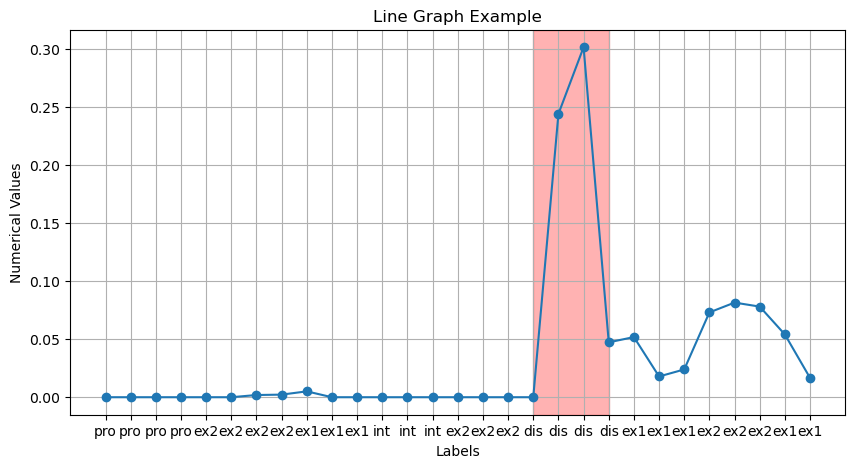

In [475]:
import matplotlib.pyplot as plt

# Example data
# Create the plot
plt.figure(figsize=(10, 5))
indices = list(range(len(state_list[:-1])))

norm_probs = sat_probs[:-1]/sat_probs[:-1].sum()

plt.plot(indices, norm_probs.tolist(), marker='o')
plt.xticks(indices, state_list[:-1])

# Adding titles and labels
plt.title('Line Graph Example')
plt.xlabel('Labels')
plt.ylabel('Numerical Values')

start = None
end = None
ix = 0
for state in state_list[:-1]:
    if state == "dis":
        if start is None:  # First occurrence
            start = ix
        end = ix  # Update end to the current index
    ix += 1

plt.axvspan(start, end, color='red', alpha=0.3)  # Pale red color

# Show the grid
plt.grid()

# Display the plot
plt.show()


# Satisifaction Probability Estimation

In [495]:
def satprob_torch_list(hmm, cst_list, obs, pro_before = 30, dtype = torch.float32,  device = 'cpu', debug = False, num_corr = 0, hmm_params = None):
    '''
    more optimized torch implementation of Viterbi. The constraint all evolve independently (ie. factorial), so no need to create a big U_krjs matrix. Instead, just multiply along given dim. Still require computing V_{krjs}, but this should help.
    For numerica underflow, we normalize the value at each time. Also, we add a small constant num_corr when normalizing.

    For DNA, always assume that the promoter constraint is first.

    Assume that last constraint is the one whose sat time to compute.
    '''
    hmm = copy.deepcopy(hmm) #protect again in place modification
    #Generate emit_weights:
    emit_weights = compute_emitweights(obs, hmm)
    emit_weights = torch.from_numpy(emit_weights).type(dtype).to(device)

    #Generate hmm,cst params:
    hmm_params, cst_params_list, state_ix = convertTensor_list(hmm,cst_list, dtype = dtype, \
                                                               device = device, return_ix = True, hmm_params = hmm_params)   
    tmat, init_prob = hmm_params
    dims_list, init_ind_list,final_ind_list,ind_list = cst_params_list

    #Assume that last constraint is the one whose sat time is estimated
    #Parameters for the other fixed constraints
    fixed_init, fixed_eval, fixed_upd = init_ind_list[:-2], final_ind_list[:-2], ind_list[:-2]

    #Parameters for estimated sat time constraint.
    sat_init, sat_true_eval, sat_upd = init_ind_list[-2:], final_ind_list[-2:], ind_list[-2:]
    sat_false_eval = [1-sat_true_eval[0], sat_true_eval[1]]
    
    #Viterbi
    T = emit_weights.shape[0]
    K = tmat.shape[0]
    C = len(dims_list)
    
    
    kr_indices = list(range(C+1))
    # fwd_kr_shape = (K,) + tuple(dims_list)
    js_indices = [k + C + 1 for k in kr_indices]


    #initialize. Let u,v denote the current/past indices of fixed constrained mediation space
    #indices are kurjvs
    alpha = torch.einsum(emit_weights[0],[0], init_prob, [0],*fixed_init, *sat_init, kr_indices)
    alpha = alpha/(alpha.max() + num_corr) #normalize for stability
    #Compute forward messages:
    for t in range(1,T-1):
        #Common terms, summing over js indices.
        if t == pro_before:
            # alpha[t] = torch.einsum(V, kr_indices, *fixed_upd[:2], kr_indices).cpu()
            
            alpha = torch.einsum(alpha, js_indices, tmat, [C+1,0], emit_weights[t],[0], \
                                       *ind_list, *final_ind_list[:2], kr_indices)
        else:
            alpha = torch.einsum(alpha, js_indices, tmat, [C+1,0], emit_weights[t],[0], \
                                       *ind_list, kr_indices)

        alpha = alpha/(alpha.max() + num_corr) #normalize for stability
    #compute final probs
    alpha_true = torch.einsum(alpha.to(device), js_indices, tmat, [C+1,0], emit_weights[t],[0], \
                               *ind_list, *fixed_eval, *sat_true_eval, kr_indices)
    alpha_false = torch.einsum(alpha.to(device), js_indices, tmat, [C+1,0], emit_weights[t],[0], \
                               *ind_list, *fixed_eval, *sat_false_eval, kr_indices)

    probs = torch.tensor([alpha_true.sum().cpu().item(), alpha_false.sum().cpu().item()] )
    probs = probs/probs.sum()
    
    return probs #, alpha_true, alpha_false

In [507]:
state_list, emit_list = simulation(hmm, time = 30, stay=3, pro_before=10, ix_list=None, max_attempts=1000)

In [508]:
sat_cst_list = [promoter_cst,stay_cst, pe_cst, hitdis_cst]


In [509]:
probs = satprob_torch_list(hmm, sat_cst_list, emit_list, pro_before = 10, dtype = torch.float32,  device = 'cpu', debug = False, num_corr = 0)

In [510]:
probs

tensor([0.7177, 0.2823])